In [12]:
import importlib
from __imports__ import *
import data, LSTM_returns, optimization
importlib.reload(data)

<module 'data' from 'c:\\Users\\27904\\OneDrive\\桌面\\crypto\\AAA_Thursday1\\data\\__init__.py'>

In [13]:
df = data.load_asset('BTCUSDT', sampling='1d')
df = data.add_fear_and_greed(df)
# Restrict data after 2022
df = df[df.index >= '2022-01-01']
df

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,F&G,F&G category
Open time,,,,,,,,,,,
2022-01-01,46216.93,47954.63,46208.37,47722.65,19604.46325,9.241552e+08,714899,9942.36679,4.687387e+08,21.0,Extreme Fear
2022-01-02,47722.66,47990.00,46654.00,47286.18,18340.46040,8.666110e+08,709624,9166.46954,4.331824e+08,29.0,Fear
2022-01-03,47286.18,47570.00,45696.00,46446.10,27662.07710,1.292204e+09,885624,13524.76045,6.318794e+08,29.0,Fear
2022-01-04,46446.10,47557.54,45500.00,45832.01,35491.41360,1.649170e+09,1021815,17689.26808,8.217255e+08,23.0,Extreme Fear
2022-01-05,45832.01,47070.00,42500.00,43451.13,51784.11857,2.334289e+09,1478532,23552.99460,1.063287e+09,24.0,Extreme Fear
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-27,86909.17,87756.39,85800.00,87232.01,17098.03897,1.487969e+09,2376381,8185.05517,7.123249e+08,40.0,Fear
2025-03-28,87232.01,87515.67,83585.00,84424.38,27182.73169,2.309947e+09,3236085,11274.83736,9.585233e+08,44.0,Fear
2025-03-29,84424.38,84624.73,81644.81,82648.54,11696.39864,9.701999e+08,2172387,5621.60485,4.662156e+08,26.0,Fear


In [14]:
import ta  # technical analysis library

look_back = 14

# RSI: Relative Strength Index
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=look_back).rsi()

<Figure size 1200x600 with 0 Axes>

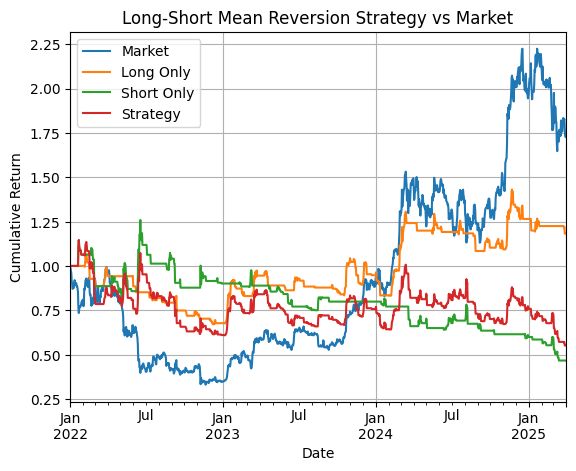

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load df
price = df['Close']

# Calculate Moving Average and Standard Deviation
window = 20
moving_avg = price.rolling(window=window).mean()
moving_std = price.rolling(window=window).std()

# Calculate Z-score
z_score = (price - moving_avg) / moving_std

df['Position'] = 0
df.loc[z_score < -1, 'Position'] = -1    # Long
df.loc[z_score > 1, 'Position'] = 1     # Short

# Shift position for realistic execution
df['Position'] = df['Position'].shift(1)

# Calculate returns
df['Market Return'] = price.pct_change()
df['Long Return'] = (df['Position'] == 1).astype(int) * df['Market Return']
df['Short Return'] = (df['Position'] == -1).astype(int) * (-df['Market Return'])
df['Strategy Return'] = df['Position'] * df['Market Return']

# Cumulative returns
cumulative_returns = (1 + df[['Market Return', 'Long Return', 'Short Return', 'Strategy Return']]).cumprod()

# Plot
plt.figure(figsize=(12, 6))
cumulative_returns.plot()
plt.title('Long-Short Mean Reversion Strategy vs Market')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend(['Market', 'Long Only', 'Short Only', 'Strategy'])
plt.grid(True)
plt.show()

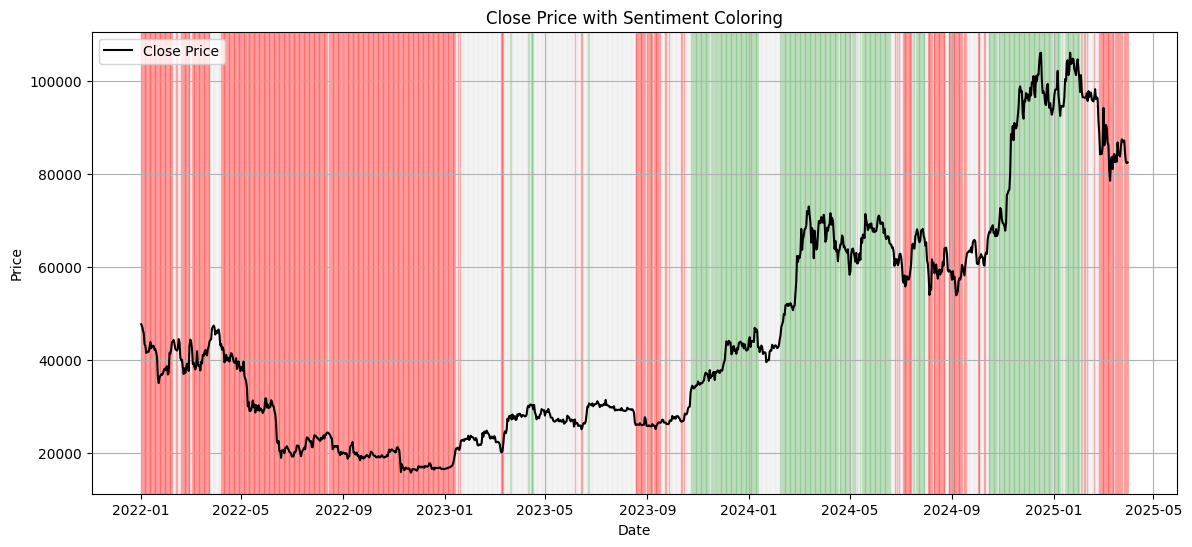

In [22]:
fear_threshold = 45
greed_threshold = 65

fig, ax = plt.subplots(figsize=(14,6))

# Plot Close price
ax.plot(df.index, df['Close'], label='Close Price', color='black')

# Color background by sentiment
for idx in range(len(df)):
    if df['F&G'].iloc[idx] <= fear_threshold:
        ax.axvspan(df.index[idx], df.index[idx], color='red', alpha=0.3)
    elif df['F&G'].iloc[idx] >= greed_threshold:
        ax.axvspan(df.index[idx], df.index[idx], color='green', alpha=0.2)
    else:
        ax.axvspan(df.index[idx], df.index[idx], color='grey', alpha=0.05)

# Decorations
plt.title('Close Price with Sentiment Coloring')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

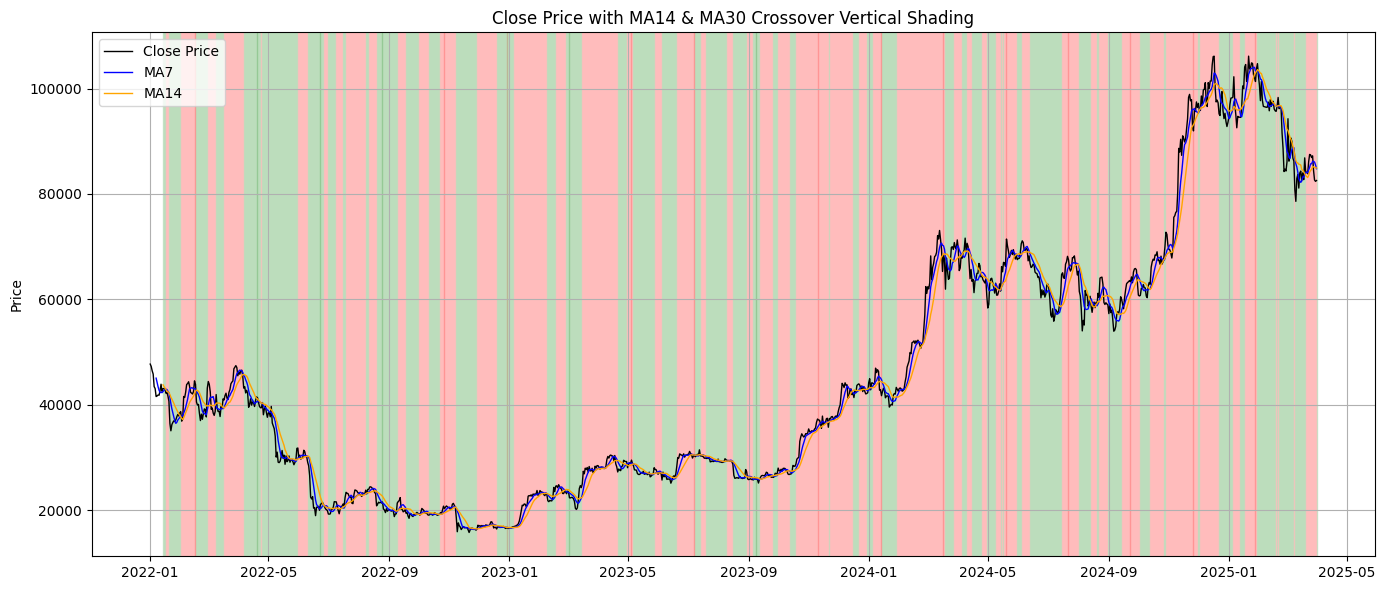

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Compute moving averages
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA14'] = df['Close'].rolling(window=14).mean()

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot price and moving averages
ax.plot(df.index, df['Close'], label='Close Price', color='black', linewidth=1)
ax.plot(df.index, df['MA7'], label='MA7', color='blue', linewidth=1)
ax.plot(df.index, df['MA14'], label='MA14', color='orange', linewidth=1)

# Shade vertical bars based on crossover
for idx in range(len(df)):
    if np.isnan(df['MA7'].iloc[idx]) or np.isnan(df['MA14'].iloc[idx]):
        continue  # Skip NaN entries
    if df['MA7'].iloc[idx] > df['MA14'].iloc[idx]:
        ax.axvspan(df.index[idx], df.index[idx], color='red', alpha=0.2)
    elif df['MA7'].iloc[idx] < df['MA14'].iloc[idx]:
        ax.axvspan(df.index[idx], df.index[idx], color='green', alpha=0.2)

# Final decorations
ax.set_title('Close Price with MA14 & MA30 Crossover Vertical Shading')
ax.set_ylabel('Price')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()



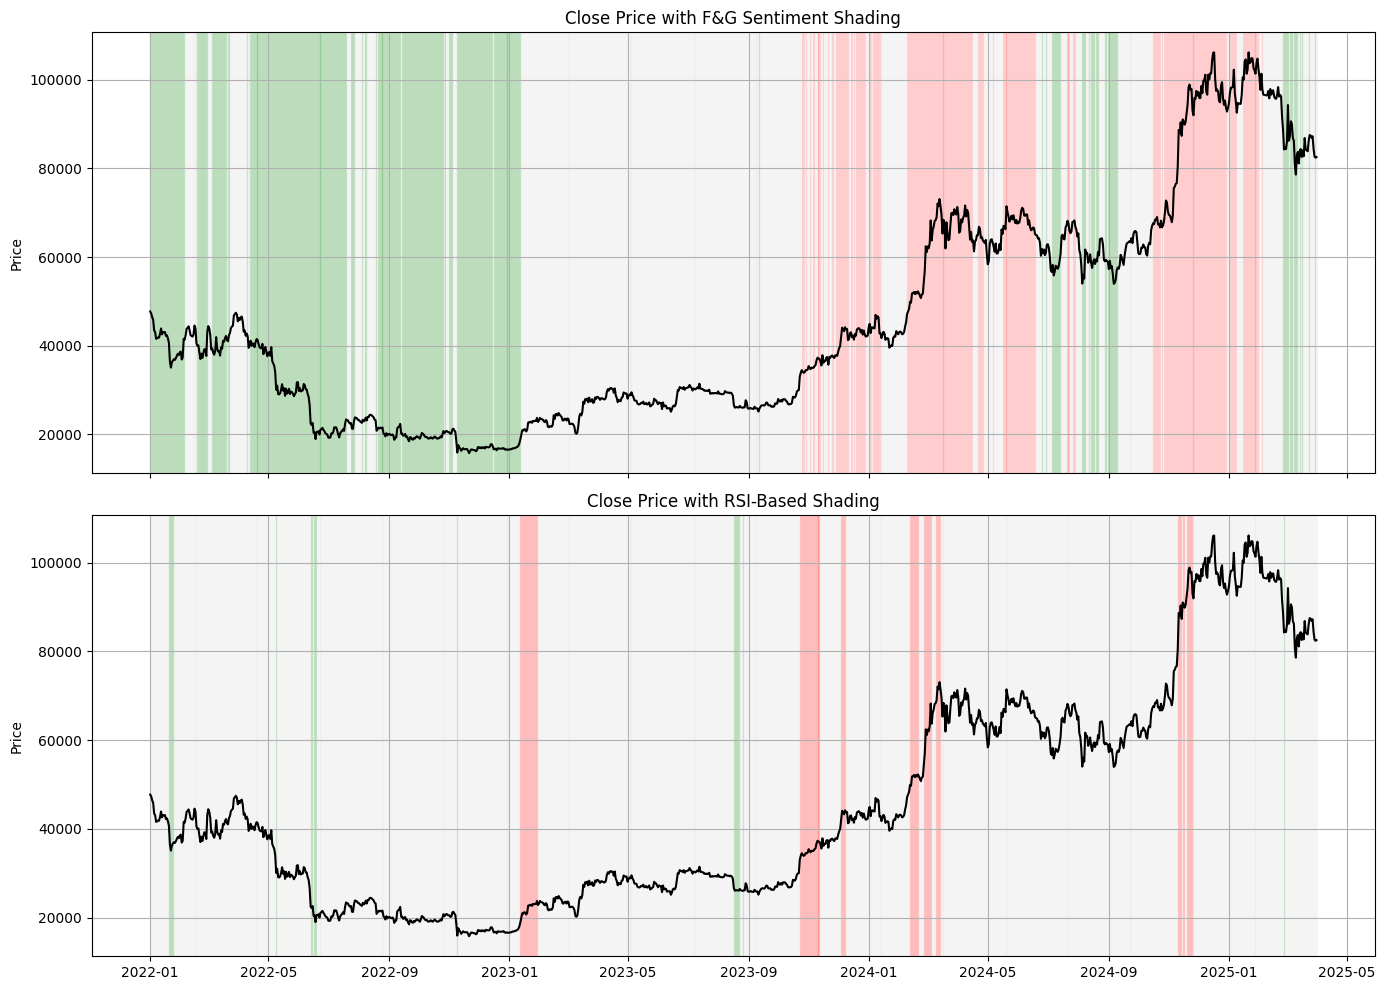

In [18]:
import matplotlib.pyplot as plt

fear_threshold = 30
greed_threshold = 70

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# ======== PLOT 1: Close Price + F&G Sentiment Color ========
ax1.plot(df.index, df['Close'], label='Close Price', color='black')

for idx in range(len(df)):
    if df['F&G'].iloc[idx] <= fear_threshold:
        ax1.axvspan(df.index[idx], df.index[idx], color='green', alpha=0.2)
    elif df['F&G'].iloc[idx] >= greed_threshold:
        ax1.axvspan(df.index[idx], df.index[idx], color='red', alpha=0.15)
    else:
        ax1.axvspan(df.index[idx], df.index[idx], color='grey', alpha=0.05)

ax1.set_title('Close Price with F&G Sentiment Shading')
ax1.set_ylabel('Price')
ax1.grid(True)

# ======== PLOT 2: Close Price + RSI Color ========
ax2.plot(df.index, df['Close'], label='Close Price', color='black')

for idx in range(len(df)):
    if df['RSI'].iloc[idx] > 75:
        ax2.axvspan(df.index[idx], df.index[idx], color='red', alpha=0.2)
    elif df['RSI'].iloc[idx] < 25:
        ax2.axvspan(df.index[idx], df.index[idx], color='green', alpha=0.2)
    else:
        ax2.axvspan(df.index[idx], df.index[idx], color='grey', alpha=0.05)

ax2.set_title('Close Price with RSI-Based Shading')
ax2.set_ylabel('Price')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [19]:
# SHORT ENTRY: Use original exit condition
short_entry = (
    (df['RSI'] > 75) |
    (df['MA7'] < df['MA14']) |
    (df['F&G'] > 70)
)

# SHORT EXIT: Use original buy condition (reversal / oversold)
short_exit = (
    (df['RSI'] < 40) &
    (df['F&G'] < 35)
)

# Initialize signal column
df['ShortSignal'] = 0
df.loc[short_entry, 'ShortSignal'] = -1  # Short position signal

# Use NaN to fill between entries and exits
df['ShortPosition'] = np.nan
df.loc[df['ShortSignal'] == -1, 'ShortPosition'] = -1
df.loc[short_exit, 'ShortPosition'] = 0

# Forward-fill and shift to simulate next-day execution
df['ShortPosition'] = df['ShortPosition'].ffill().fillna(0)
df['ShortPosition'] = df['ShortPosition'].shift(1).fillna(0)


In [20]:
# Daily market return
df['Market Return'] = df['Close'].pct_change()

# Strategy return = market return only when in position
df['Strategy Return'] = df['Position'] * -df['Market Return']

# Cumulative returns
df['Cumulative Market Return'] = (1 + df['Market Return']).cumprod()
df['Cumulative Strategy Return'] = (1 + df['Strategy Return']).cumprod()


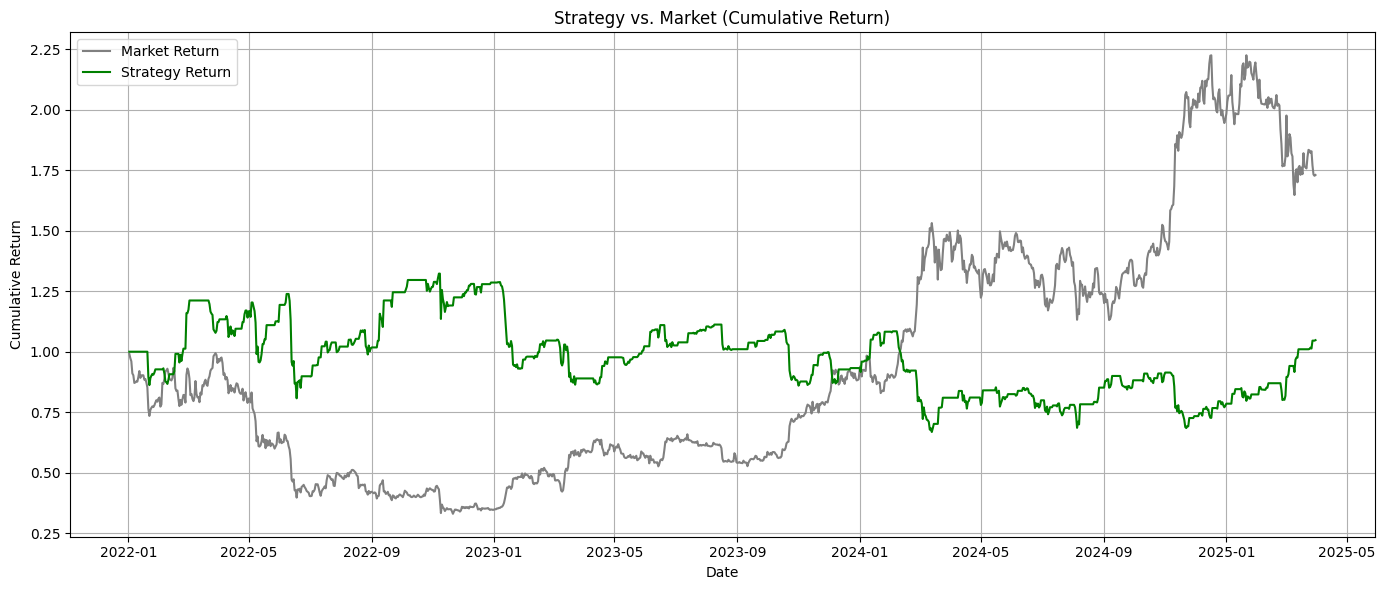

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Cumulative Market Return'], label='Market Return', color='grey')
plt.plot(df.index, df['Cumulative Strategy Return'], label='Strategy Return', color='green')
plt.title('Strategy vs. Market (Cumulative Return)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
